In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', family='serif')
rc('figure', facecolor='w')
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import fits, ascii
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
from collections import OrderedDict
from scipy.interpolate import UnivariateSpline
import os, math
from natsort import natsorted as nsort

import TheCannon
from TheCannon import apogee, dataset, model
import apogee_tools as ap
AP_PATH = os.environ['APOGEE_DATA']

line_list = ap.lines
line_names = line_list.keys()

/home/jess/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [36]:
mann_xm1 = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/raw_data_files/mann_89_APOGEE_x_Gaia.csv')
mann_teff = np.array(mann_xm1['TEFF'])
mann_fe_h = np.array(mann_xm1['FE_H'])
mann_bp_rp = mann_xm1['phot_bp_mean_mag'] - mann_xm1['phot_rp_mean_mag']
mann_g_abs = mann_xm1['phot_g_mean_mag'] + 5*np.log10(mann_xm1['parallax'])-10
mann_dist = 1/np.array(mann_xm1['parallax'])
mann_ra = np.array(mann_xm1['RA_1'])
mann_dec = np.array(mann_xm1['DEC_1'])

mann_results = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/train_mann/results/test_results.csv')

In [177]:
list(mann_xm1.keys())

['DEC_1',
 'FE_H',
 'ID',
 'RA_1',
 'SOURCE',
 'TEFF',
 'dist',
 'table1_oid',
 'angdist',
 'APOGEE_ID',
 'ra_APOGEE',
 'dec_APOGEE',
 'glon_APOGEE',
 'glat_APOGEE',
 'ra_epoch2000',
 'dec_epoch2000',
 'errhalfmaj',
 'errhalfmin',
 'errposang',
 'solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra_2',
 'ra_error',
 'dec_2',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colo

In [167]:
test = pd.read_csv('test_results/test_mann_x_APASS_x_SDSS.csv')
test['K_ABS'] = test['K'] + 5*np.log10(test['PLX'])-10

In [121]:
test = test[test['CHI'] < 80000]
test = test[(test['FE_H'] > -.5) & (test['FE_H'] < .5)]

In [122]:
test.keys()

Index(['col1', 'BP_RP', 'CHI', 'DEC', 'DIST', 'FE_H', 'G_ABS', 'H', 'ID', 'J',
       'K', 'PLX', 'PLX_ERR', 'RA', 'TEFF', 'X', 'Y', 'Z', 'RAJ2000',
       'DEJ2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'field', 'nobs',
       'mobs', 'B-V', 'e_B-V', 'Vmag', 'e_Vmag', 'u_e_Vmag', 'Bmag', 'e_Bmag',
       'u_e_Bmag', 'gpmag', 'e_gpmag', 'u_e_gpmag', 'rpmag', 'e_rpmag',
       'u_e_rpmag', 'ipmag', 'e_ipmag', 'u_e_ipmag', 'angDist', 'RAdeg',
       'DEdeg', 'errHalfMaj_x', 'errHalfMin_x', 'errPosAng_x', 'objID', 'mode',
       'q_mode', 'class', 'SDSS12', 'm_SDSS12', 'flags', 'ObsDate', 'Q',
       'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag',
       'zmag', 'e_zmag', 'zsp', 'e_zsp', 'f_zsp', 'zph', 'e_zph', 'avg_zph',
       'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'SpObjID', 'spType', 'spCl',
       'subClass', 'angDist_x'],
      dtype='object')

5707


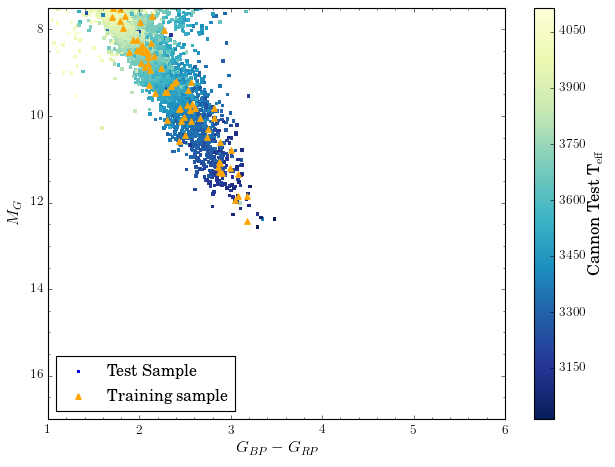

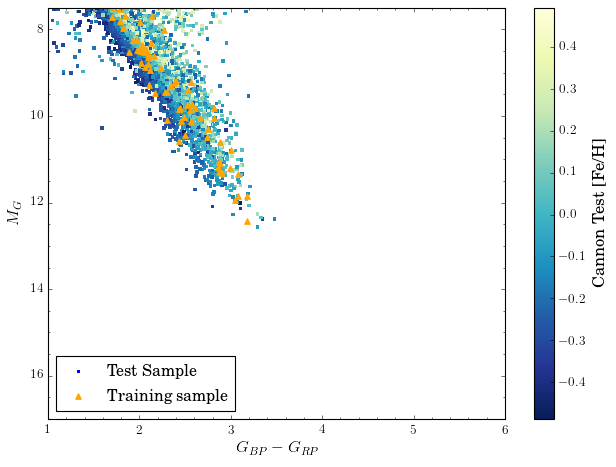

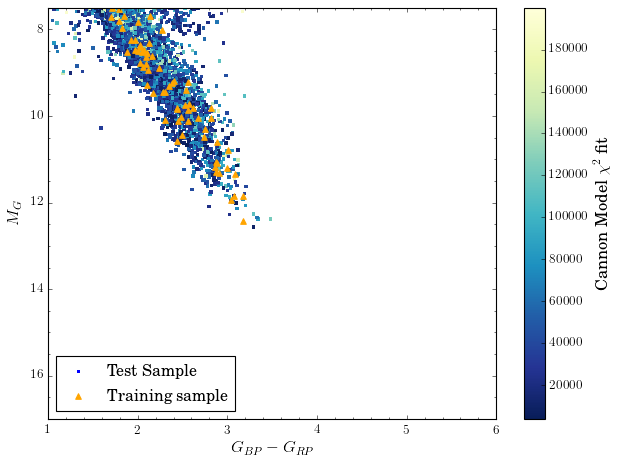

In [151]:
print(len(test['BP_RP']))

pl = plt.scatter(test['BP_RP'], test['G_ABS'], c=test['TEFF'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test Sample')
plt.scatter(mann_bp_rp, mann_g_abs, color='orange', marker='^', label='Training sample', s=25)
cb = plt.colorbar(pl)
cb.set_label(r'Cannon Test T$_{\rm eff}$', fontsize=15)
plt.xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
plt.ylabel(r'$M_{G}$', fontsize=15)
plt.ylim(17,7.5)
plt.xlim(1,6)
plt.legend(loc='lower left', scatterpoints=1)
plt.minorticks_on()
plt.tight_layout()
plt.show()

#=============

pl = plt.scatter(test['BP_RP'], test['G_ABS'], c=test['FE_H'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test Sample')
plt.scatter(mann_bp_rp, mann_g_abs, color='orange', marker='^', label='Training sample', s=25)
cb = plt.colorbar(pl)
cb.set_label(r'Cannon Test [Fe/H]', fontsize=15)
plt.xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
plt.ylabel(r'$M_{G}$', fontsize=15)
plt.ylim(17,7.5)
plt.xlim(1,6)
plt.legend(loc='lower left', scatterpoints=1)
plt.minorticks_on()
plt.tight_layout()
plt.show()

#=============

# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[16,4])
pl = plt.scatter(test['BP_RP'], test['G_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test Sample')
plt.scatter(mann_bp_rp, mann_g_abs, color='orange', marker='^', label='Training sample', s=25)
cb = plt.colorbar(pl)
cb.set_label(r'Cannon Model $\chi^2$ fit', fontsize=15)
plt.xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
plt.ylabel(r'$M_{G}$', fontsize=15)
plt.ylim(17,7.5)
plt.xlim(1,6)
plt.legend(loc='lower left', scatterpoints=1)
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [152]:
v_j = np.array(test['Vmag'] - test['J'])
r_z = np.array(test['rmag'] - test['zmag'])
r_j = np.array(test['rmag'] - test['J'])

bp_rp_teff = 3500*(3.245 - 2.4309*test['BP_RP'] + 1.043*(test['BP_RP'])**2 - .2127*(test['BP_RP'])**3 + .01649*(test['BP_RP'])**4)
bp_rp_teff2 = 3500*(2.835 - 1.893*test['BP_RP'] + .7860*(test['BP_RP'])**2 - .1594*(test['BP_RP'])**3 + .01243*(test['BP_RP'])**4 + .04417*test['FE_H'])
vj_teff = 3500*(2.840 - 1.3453*v_j + .3906*(v_j)**2 - .0546*(v_j)**3 + .002913*(v_j)**4)
vj_teff2 = 3500*(2.515 - 1.054*v_j + 0.2965*(v_j)**2 - 0.04150*(v_j)**3 + 0.002245*(v_j)**4 + 0.05262*test['FE_H'])
rz_teff = 3500*(1.547 - 0.7053*r_z + 0.3656*(r_z)**2 - 0.1008*(r_z)**3 + 0.01046*(r_z)**4)
rz_teff2 = 3500*(1.572 - 0.7220*r_z + 0.3560*(r_z)**2 - 0.09221*(r_z)**3 + 0.009071*(r_z)**4 + 0.05220*test['FE_H'])
rj_teff = 3500*(2.445 - 1.2578*r_j + 0.4340*(r_j)**2 - 0.0720*(r_j)**3 + 0.004502*(r_j)**4)
rj_teff2 = 3500*(2.532 - 1.319*r_j + 0.4449*(r_j)**2 - 0.07151*(r_j)**3 + 0.004333*(r_j)**4 + 0.05629*test['FE_H'])

bp_rp_diff = test['TEFF'] - bp_rp_teff
bp_rp_diff2 = test['TEFF'] - bp_rp_teff2
vj_diff = test['TEFF'] - vj_teff
vj_diff2 = test['TEFF'] - vj_teff2
rz_diff = test['TEFF'] - rz_teff
rz_diff2 = test['TEFF'] - rz_teff2
rj_diff = test['TEFF'] - rj_teff
rj_diff2 = test['TEFF'] - rj_teff2

5707


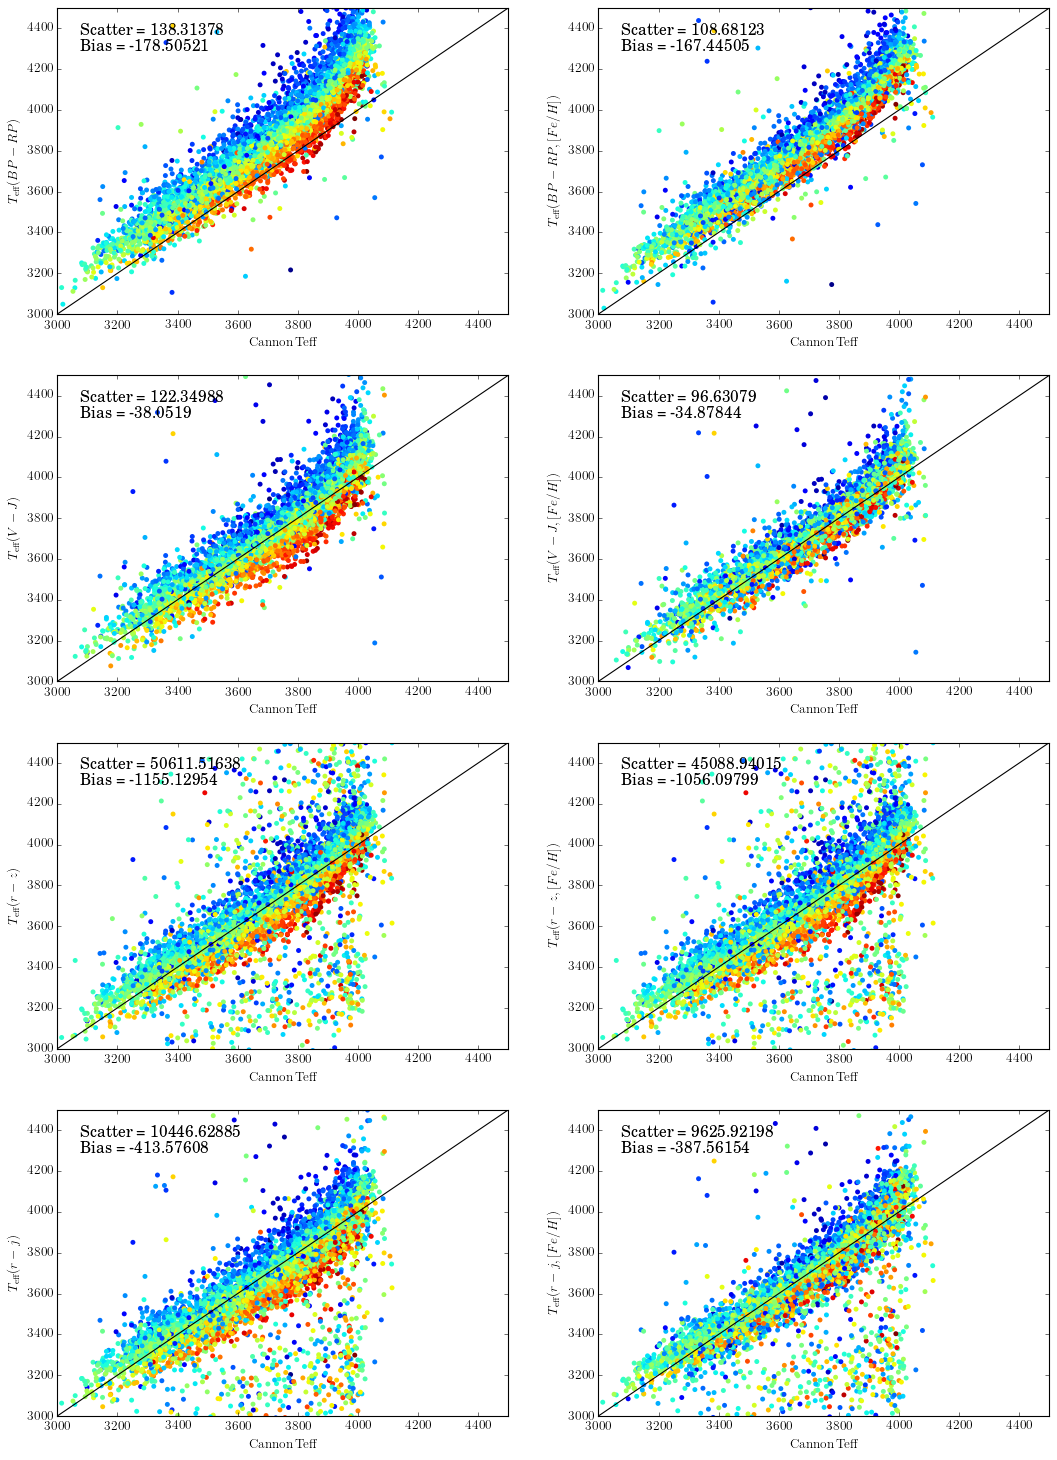

In [155]:
print(len(test))
x = np.linspace(2000,5000)
text1 = 'Scatter = %s \n Bias = %s'%(round(np.std(bp_rp_diff),5), round(np.mean(bp_rp_diff),5))
text2 = 'Scatter = %s \n Bias = %s'%(round(np.std(bp_rp_diff2),5), round(np.mean(bp_rp_diff2),5))
text3 = 'Scatter = %s \n Bias = %s'%(round(np.std(vj_diff),5), round(np.mean(vj_diff),5))
text4 = 'Scatter = %s \n Bias = %s'%(round(np.std(vj_diff2),5), round(np.mean(vj_diff2),5))
text5 = 'Scatter = %s \n Bias = %s'%(round(np.std(rz_diff),5), round(np.mean(rz_diff),5))
text6 = 'Scatter = %s \n Bias = %s'%(round(np.std(rz_diff2),5), round(np.mean(rz_diff2),5))
text7 = 'Scatter = %s \n Bias = %s'%(round(np.std(rj_diff),5), round(np.mean(rj_diff),5))
text8 = 'Scatter = %s \n Bias = %s'%(round(np.std(rj_diff2),5), round(np.mean(rj_diff2),5))

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=[16,22])

ax1.plot(x,x, color='k')
ax1.text(0.05, 0.95, text1, fontsize=14, transform=ax1.transAxes, verticalalignment='top')
ax1.scatter(test['TEFF'], bp_rp_teff, edgecolor='none', c=test['FE_H'])
ax1.set_xlim(3000,4500)
ax1.set_ylim(3000,4500)
ax1.set_ylabel(r'$T_{\rm eff}(BP-RP)$')
ax1.set_xlabel(r'$\rm Cannon \, Teff$')

ax2.plot(x,x, color='k')
ax2.text(0.05, 0.95, text2, fontsize=14, transform=ax2.transAxes, verticalalignment='top')
ax2.scatter(test['TEFF'], bp_rp_teff2, edgecolor='none', c=test['FE_H'])
ax2.set_xlim(3000,4500)
ax2.set_ylim(3000,4500)
ax2.set_ylabel(r'$T_{\rm eff}(BP-RP, [Fe/H])$')
ax2.set_xlabel(r'$\rm Cannon \, Teff$')

ax3.plot(x,x, color='k')
ax3.text(0.05, 0.95, text3, fontsize=14, transform=ax3.transAxes, verticalalignment='top')
ax3.scatter(test['TEFF'], vj_teff, edgecolor='none', c=test['FE_H'])
ax3.set_xlim(3000,4500)
ax3.set_ylim(3000,4500)
ax3.set_ylabel(r'$T_{\rm eff}(V-J)$')
ax3.set_xlabel(r'$\rm Cannon \, Teff$')

ax4.plot(x,x, color='k')
ax4.text(0.05, 0.95, text4, fontsize=14, transform=ax4.transAxes, verticalalignment='top')
ax4.scatter(test['TEFF'], vj_teff2, edgecolor='none', c=test['FE_H'])
ax4.set_xlim(3000,4500)
ax4.set_ylim(3000,4500)
ax4.set_ylabel(r'$T_{\rm eff}(V-J, [Fe/H])$')
ax4.set_xlabel(r'$\rm Cannon \, Teff$')

ax5.plot(x,x, color='k')
ax5.text(0.05, 0.95, text5, fontsize=14, transform=ax5.transAxes, verticalalignment='top')
ax5.scatter(test['TEFF'], rz_teff, edgecolor='none', c=test['FE_H'])
ax5.set_xlim(3000,4500)
ax5.set_ylim(3000,4500)
ax5.set_ylabel(r'$T_{\rm eff}(r-z)$')
ax5.set_xlabel(r'$\rm Cannon \, Teff$')

ax6.plot(x,x, color='k')
ax6.text(0.05, 0.95, text6, fontsize=14, transform=ax6.transAxes, verticalalignment='top')
ax6.scatter(test['TEFF'], rz_teff, edgecolor='none', c=test['FE_H'])
ax6.set_xlim(3000,4500)
ax6.set_ylim(3000,4500)
ax6.set_ylabel(r'$T_{\rm eff}(r-z, [Fe/H])$')
ax6.set_xlabel(r'$\rm Cannon \, Teff$')

ax7.plot(x,x, color='k')
ax7.text(0.05, 0.95, text7, fontsize=14, transform=ax7.transAxes, verticalalignment='top')
ax7.scatter(test['TEFF'], rj_teff, edgecolor='none', c=test['FE_H'])
ax7.set_xlim(3000,4500)
ax7.set_ylim(3000,4500)
ax7.set_ylabel(r'$T_{\rm eff}(r-j)$')
ax7.set_xlabel(r'$\rm Cannon \, Teff$')

ax8.plot(x,x, color='k')
ax8.text(0.05, 0.95, text8, fontsize=14, transform=ax8.transAxes, verticalalignment='top')
ax8.scatter(test['TEFF'], rj_teff2, edgecolor='none', c=test['FE_H'])
ax8.set_xlim(3000,4500)
ax8.set_ylim(3000,4500)
ax8.set_ylabel(r'$T_{\rm eff}(r-j, [Fe/H])$')
ax8.set_xlabel(r'$\rm Cannon \, Teff$')

plt.show()

5707


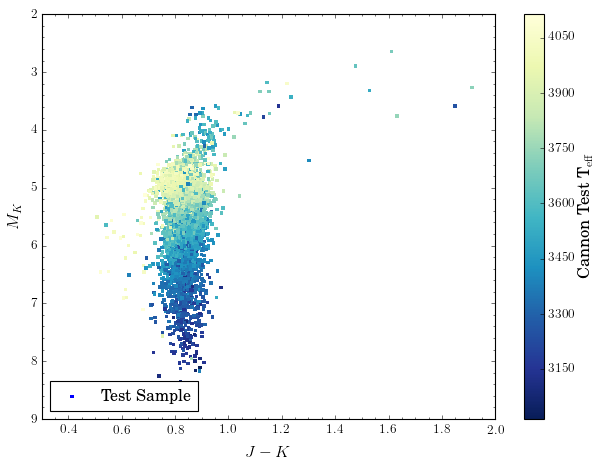

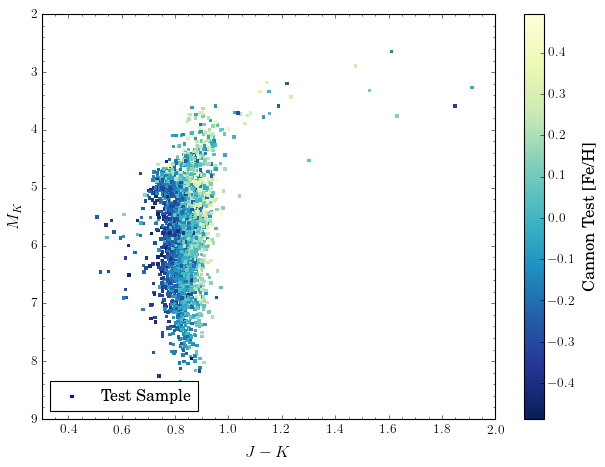

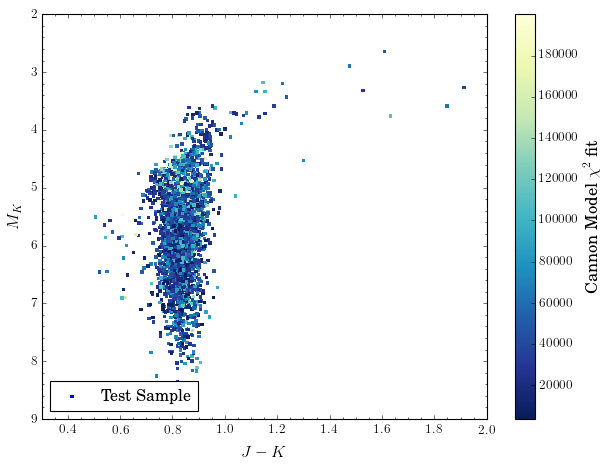

In [174]:
print(len(test['BP_RP']))

pl = plt.scatter(test['J'] - test['K'], test['K_ABS'], c=test['TEFF'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test Sample')
# plt.scatter(mann_bp_rp, mann_g_abs, color='orange', marker='^', label='Training sample', s=25)
cb = plt.colorbar(pl)
cb.set_label(r'Cannon Test T$_{\rm eff}$', fontsize=15)
plt.xlabel(r'$J-K$', fontsize=15)
plt.ylabel(r'$M_{K}$', fontsize=15)
# plt.ylim(17,7.5)
# plt.xlim(1,6)
plt.legend(loc='lower left', scatterpoints=1)
plt.minorticks_on()
plt.tight_layout()
plt.ylim(9,2)
plt.xlim(.3,2)
plt.show()

#=============

pl = plt.scatter(test['J'] - test['K'], test['K_ABS'], c=test['FE_H'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test Sample')
# plt.scatter(mann_bp_rp, mann_g_abs, color='orange', marker='^', label='Training sample', s=25)
cb = plt.colorbar(pl)
cb.set_label(r'Cannon Test [Fe/H]', fontsize=15)
plt.xlabel(r'$J-K$', fontsize=15)
plt.ylabel(r'$M_{K}$', fontsize=15)
plt.legend(loc='lower left', scatterpoints=1)
plt.minorticks_on()
plt.tight_layout()
plt.ylim(9,2)
plt.xlim(.3,2)
plt.show()

#=============

# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[16,4])
pl = plt.scatter(test['J'] - test['K'], test['K_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test Sample')
# plt.scatter(mann_bp_rp, mann_g_abs, color='orange', marker='^', label='Training sample', s=25)
cb = plt.colorbar(pl)
cb.set_label(r'Cannon Model $\chi^2$ fit', fontsize=15)
plt.xlabel(r'$J-K$', fontsize=15)
plt.ylabel(r'$M_{K}$', fontsize=15)
plt.legend(loc='lower left', scatterpoints=1)
plt.minorticks_on()
plt.tight_layout()
plt.ylim(9,2)
plt.xlim(.3,2)
plt.show()